In [27]:
import os
import re
import xgboost
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [28]:
train = pd.read_csv("../input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")

train.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


review       0
sentiment    0
dtype: int64


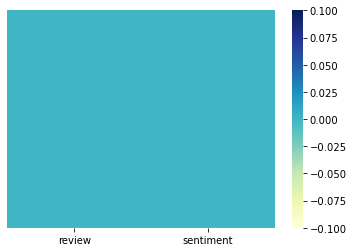

In [29]:
#Let's see if we have any null/NaN values in dataset
print(train.isnull().sum())

#Plotting it using seaborn heatmap
sns.heatmap(train.isnull(), yticklabels=False, cmap="YlGnBu")

In [30]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [31]:
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')

In [32]:
#Preprocessing
 
#converting to lower case
train["review"] = train["review"].apply(lambda x: x.lower()) 
#removing everything instead of 0-9, a-z, A-Z
train["review"] = train["review"].apply(lambda x: re.sub("[^0-9a-zA-Z]"," ", x))
#removing html tags
clean_html = re.compile('<.*?>')
train["review"] = train["review"].apply(lambda x: re.sub(clean_html, "", x))
#lemmatizing
train["review"] = train["review"].apply(lambda x: lemmatizer.lemmatize(x))
#removing extra white spaces
train["review"] = train["review"].apply(lambda x: re.sub(" +"," ", x) )

In [33]:
vectorizer = TfidfVectorizer(use_idf = True,
                             lowercase = True, 
                             strip_accents='ascii',
                             stop_words=stop_words)

In [34]:
X = vectorizer.fit_transform(train["review"])

label_encoding = {
    "positive": 1,
    "negative": 0
}

label_decoding = {
    1: "positive",
    0: "negative"
}

y = train["sentiment"].map(label_encoding).to_list()

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#### First I would like to go with MultinomialNB as it works very good for textual data.

In [36]:
clf = MultinomialNB()

clf.fit(X_train, y_train)

MultinomialNB()

In [37]:
y_pred = clf.predict(X_test)

print("Accuracy : {} %".format(round(accuracy_score(y_test, y_pred)*100, 4)))

Accuracy : 86.57 %


#### Okay so the base model that was the MultinomialNB gives us an accuracy of ~ 87%
#### Let's try another classifier, I'm going to use RandomForestClassifier as it works like a charm for any problem!

In [38]:
clf_rf = RandomForestClassifier()

clf_rf.fit(X_train, y_train)

y_pred_rf = clf_rf.predict(X_test)

print("Accuracy : {} %".format(round(accuracy_score(y_test, y_pred_rf)*100, 4)))

Accuracy : 85.85 %


#### Let's do some hyperparameter tuning and see if we can improve the accuracy further

In [ ]:
#Selecting hyper-parameters in RandomForestClassifier

#Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
#Number of features to consider at every split
max_features = ['auto', 'sqrt']
#Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
#Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
#Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
#Method of selecting samples for training each tree
bootstrap = [True, False]

#Creating a random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
#Using RandomizedSearchCV for selecting best hyper-parameters
#On each iteration, the algorithm will choose a difference combination of the features
#the benefit of a random search is that we are not trying every combination, 
#but selecting at random to sample a wide range of values.

#n_iter = number of different combinations to try
#cv = number of folds to use for cross validation

randomizedSearch = RandomizedSearchCV(estimator=clf_rf,
                                     param_distributions=random_grid,
                                     n_iter=10,
                                     n_jobs=-1,
                                     cv=3,
                                     verbose=2,
                                     random_state=42)

randomizedSearch.fit(X_train, y_train)

In [ ]:
#Best parameters after performing RandomizedSearchCV
print(randomizedSearch.best_params_)

#Getting the best estimator after performing RandomizedSearchCV
randomSearchModel = randomizedSearch.best_estimator_

y_pred = randomSearchModel.predeict(X_test, y_test)

print("Accuracy : {} %".format(round(accuracy_score(y_test, y_pred)*100, 4)))

#### RandomForest was taking a long time when training, so i skipped it.

#### Now I'm trying XGBoost Classifier

In [39]:
xgb = xgboost.XGBClassifier()

xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [40]:
y_pred_xgb = xgb.predict(X_test)

print("Accuracy : {} %".format(round(accuracy_score(y_test, y_pred_xgb)*100, 4)))

Accuracy : 85.88 %


In [41]:
param_grid = {"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
              "max_depth"        : [3, 4, 5, 6, 8, 10, 12, 15],
              "min_child_weight" : [1, 3, 5, 7],
              "gamma"            : [0.0, 0.1, 0.2 , 0.3, 0.4],
              "colsample_bytree" : [0.3, 0.4, 0.5 , 0.7]}

randomXgb = RandomizedSearchCV(estimator=xgb,
                               param_distributions=param_grid,
                               n_iter=20,
                               n_jobs=-1,
                               verbose=2,
                               cv=3,
                               random_state=42)

In [42]:
finalXGB = randomXgb.estimator

print(randomXgb.get_params)

<bound method BaseEstimator.get_params of RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           gpu_id=-1, importance_type='gain',
                                           interaction_constraints='',
                                           learning_rate=0.300000012,
                                           max_delta_step=0, max_depth=6,
                                           min_child_weight=1, missing=nan,
                                           monotone_constraints='()',
                                           n_estimators=100, n_jobs=0,
                                           num_pa...
                                           reg_alpha=0, reg_lambda=1,
                        

In [43]:
y_pred_xgb = finalXGB.predict(X_test)

print("Accuracy : {} %".format(round(accuracy_score(y_test, y_pred_xgb)*100, 4)))

Accuracy : 85.88 %


### So at last, MultinomialNB gave us highest accuracy of ~87%, so we will go with that!